#### 0925 과제
- MNIST CNN 모델 만들기
- 책에 있는거 

- DNN, CNN 비교

In [6]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # Data 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader


In [7]:
# 장치 사용
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")

Using device: cpu


In [14]:
# DataSet 내려받기
train_dataset = torchvision.datasets.FashionMNIST("../data/MNIST/", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("../chap05/MNIST/", download=True, train = False, transform=transforms.Compose([transforms.ToTensor()]))

100.0%


Extracting ../data/MNIST/FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data/MNIST/FashionMNIST\raw



100.0%


Extracting ../data/MNIST/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data/MNIST/FashionMNIST\raw



100.0%


Extracting ../data/MNIST/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data/MNIST/FashionMNIST\raw



100.0%


Extracting ../data/MNIST/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/MNIST/FashionMNIST\raw



100.0%


Extracting ../chap05/MNIST/FashionMNIST\raw\train-images-idx3-ubyte.gz to ../chap05/MNIST/FashionMNIST\raw



100.0%


Extracting ../chap05/MNIST/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../chap05/MNIST/FashionMNIST\raw



100.0%


Extracting ../chap05/MNIST/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../chap05/MNIST/FashionMNIST\raw



100.0%

Extracting ../chap05/MNIST/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../chap05/MNIST/FashionMNIST\raw



In [15]:
# Fashion Data를 DataLoader에 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100)

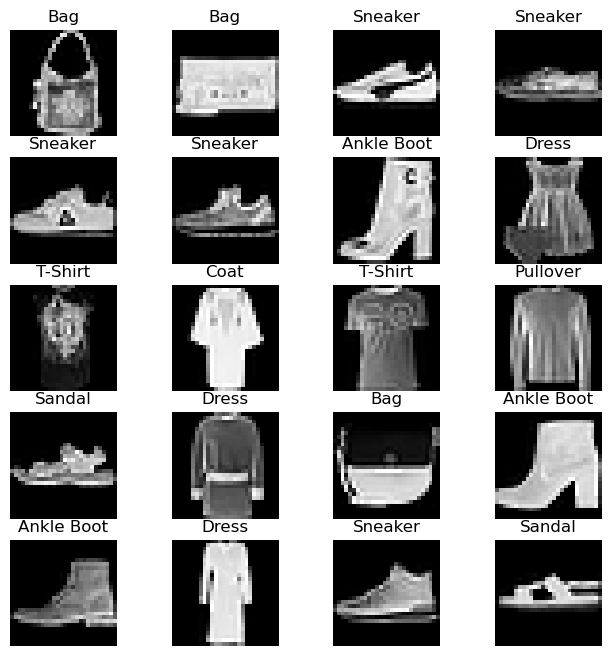

In [16]:
# 분류에 사용될 클래스 정의
labels_map = {0: "T-Shirt", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle Boot"}

fig = plt.figure(figsize = (8,8))
columns = 4
rows = 5
for i in range(1, columns*rows + 1) :
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

[DNN 모델 생성]

In [21]:
class FashionDNN(nn.Module) :
    def __init__(self) :
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data) :
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [22]:
LR = 0.001 
model = FashionDNN()
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()       # 분류에서 사용하는 손실함수
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [23]:
# 모델학습
EPOCH = 5
CNT = 5

loss_list = []
ilteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(EPOCH) :
    for images, labels in train_loader :
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        train = Variable(images.view(100, 1, 28, 28))       # 자동미분 함수
        labels = Variable(labels)

        # 학습데이터를 모델에 적용
        outputs = model(train)  
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        CNT += 1

        if not( CNT% 50) : 
            total = 0
            correct = 0
            for images, labels in test_loader :
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                labels_list.append(labels)

                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(DEVICE)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            ilteration_list.append(CNT)
            accuracy_list.append(accuracy)

            if not (CNT% 50) :
                print("Iteration : {}, Loss : {}, Accuracy : {}%".format(CNT, loss.data, accuracy))

Iteration : 50, Loss : 0.7398998141288757, Accuracy : 68.55999755859375%
Iteration : 100, Loss : 0.7164323329925537, Accuracy : 76.19000244140625%
Iteration : 150, Loss : 0.60495924949646, Accuracy : 78.1500015258789%
Iteration : 200, Loss : 0.5995439291000366, Accuracy : 80.3499984741211%
Iteration : 250, Loss : 0.5359340906143188, Accuracy : 81.20999908447266%
Iteration : 300, Loss : 0.6844025254249573, Accuracy : 80.36000061035156%
Iteration : 350, Loss : 0.43487033247947693, Accuracy : 80.19000244140625%
Iteration : 400, Loss : 0.4239047169685364, Accuracy : 81.54000091552734%
Iteration : 450, Loss : 0.3675592839717865, Accuracy : 82.4800033569336%
Iteration : 500, Loss : 0.5078640580177307, Accuracy : 82.9800033569336%
Iteration : 550, Loss : 0.479965478181839, Accuracy : 83.37999725341797%
Iteration : 600, Loss : 0.40752890706062317, Accuracy : 83.5199966430664%
Iteration : 650, Loss : 0.38559699058532715, Accuracy : 83.7300033569336%
Iteration : 700, Loss : 0.48306673765182495, 

[합성곱 (CNN) 네트워크 생성]

In [32]:
class FashionCNN(nn.Module) :
    def __init__(self) :
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels=32, kernel_size = 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # => input : (32, 28, 28)
        # => out_put: (32, 14, 14)

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # => input : (32, 14, 14)           # valid 일 때 : 기존 값 - (k-1) = 값    ex) 14 - (3-1) = 12인데 valid라서 반틈 ==> 6이 나옴 
        # => out_put : (64, 6, 6)           #                         k = kernel_size

        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)      # 마지막층의 out_feature은 클래스 개수를 의미함

    def forward(self, x) :
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [33]:
# 합성곱 네트워크를 위한 파라미터 정의
LR = 0.001
model = FashionCNN()
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [34]:
# Model 학습 및 성능 평가
EPOCH = 5
CNT = 5

loss_list = []
ilteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(EPOCH) :
    for images, labels in train_loader :
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        train = Variable(images.view(100, 1, 28, 28))       # 자동미분 함수
        labels = Variable(labels)

        # 학습데이터를 모델에 적용
        outputs = model(train)  
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        CNT += 1

        if not( CNT% 50) : 
            total = 0
            correct = 0
            for images, labels in test_loader :
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                labels_list.append(labels)

                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(DEVICE)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            ilteration_list.append(CNT)
            accuracy_list.append(accuracy)

            if not (CNT% 50) :
                print("Iteration : {}, Loss : {}, Accuracy : {}%".format(CNT, loss.data, accuracy))

c:\Users\hwans\anaconda3\envs\TORCH_CV_38\lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration : 50, Loss : 0.5006824731826782, Accuracy : 78.56999969482422%
Iteration : 100, Loss : 0.5264279842376709, Accuracy : 84.5%
Iteration : 150, Loss : 0.45450055599212646, Accuracy : 84.33000183105469%
Iteration : 200, Loss : 0.47635143995285034, Accuracy : 86.26000213623047%
Iteration : 250, Loss : 0.43438971042633057, Accuracy : 85.51000213623047%
Iteration : 300, Loss : 0.5244506597518921, Accuracy : 86.19000244140625%
Iteration : 350, Loss : 0.31326550245285034, Accuracy : 85.86000061035156%
Iteration : 400, Loss : 0.40360915660858154, Accuracy : 86.48999786376953%
Iteration : 450, Loss : 0.2301120162010193, Accuracy : 86.66000366210938%
Iteration : 500, Loss : 0.3656785190105438, Accuracy : 88.19000244140625%
Iteration : 550, Loss : 0.315186470746994, Accuracy : 87.80000305175781%
Iteration : 600, Loss : 0.40759986639022827, Accuracy : 87.12999725341797%
Iteration : 650, Loss : 0.2530542016029358, Accuracy : 88.54000091552734%
Iteration : 700, Loss : 0.4357132613658905, Acc